In [2]:
import numpy as np
import keras
import h5py
import os

import matplotlib.pyplot as plt
%matplotlib inline

# Params 

In [3]:
PATCH_SIZE = 32               # size of the receiptive field 
BATCH_SIZE = 4                # batch size used during training (> 4 does not fit into memory - GTX1070)
NUM_EPOCHS = 10               # number of complete iterations on the traning set  

# Load datasets (train + val) 

- I wrote a Python generator that **yields numpy arrays from the HDF5 files**.
- This generator provides an efficient way to manage large datasets in memory and on disk. 
- I followed the structure of `NumpyArrayIterator` implemented directly in Keras.

In [4]:
from utils import HDF5Generator

In [5]:
# the first interface is the `HDF5Generator`
# just need to give the pass to the *.h5 files
h5_generator_train = HDF5Generator("data/train_all_classes.h5")
h5_generator_val = HDF5Generator("data/val_all_classes.h5")

# we can get the numver of samples stored
# x and y are keys (as strings) used to store the images (aerial RBG images) and the target images (count maps)
num_samples_train, x_shape, y_shape = h5_generator_train.get_num_samples(x='imgs', y='target_imgs', return_shapes=True)
num_samples_val = h5_generator_val.get_num_samples(x='imgs', y='target_imgs')

print("num_samples_train : {}".format(num_samples_train))
print("num_samples_val : {}".format(num_samples_val))

print('imgs_shape : {}'.format(x_shape))
print('targets_shape  : {}'.format(y_shape))

num_samples_train : 15713
num_samples_val : 1247
imgs_shape : (256, 256, 3)
targets_shape  : (288, 288, 1)


In [6]:
# here we use the second interface : HDF5Iterator
# these object is generated by the method .flow() from an HDF5Generator
# we have the give the keys `imgs` and `target_imgs`
# here, just for testing, we don't apply normaliation
# normalization=True : /127.5, then -1, to get pixel values into [-1, 1]
# and we can shuffle the data (take random batches) : to use for the training data

h5_iterator_train = h5_generator_train.flow(x='imgs', y='target_imgs', normalization=False,
                                            batch_size=BATCH_SIZE, shuffle=True)

h5_iterator_val = h5_generator_val.flow(x='imgs', y='target_imgs', normalization=False,
                                        batch_size=BATCH_SIZE, shuffle=False)

In [7]:
# then with the method .next() we can generate one batch of data
# `with_counts=True` : return an array containing the number of sea lion per image
batch_x, batch_y, counts = h5_iterator_train.next(with_counts=True)
print("batch_x : {}  |  {}".format(batch_x.shape, batch_x.dtype))
print("batch_y : {}  |  {}".format(batch_y.shape, batch_y.dtype))
print("counts : {}  |  {}".format(counts.shape, counts.dtype))

batch_x : (4, 256, 256, 3)  |  float32
batch_y : (4, 288, 288, 1)  |  float32
counts : (4,)  |  uint8


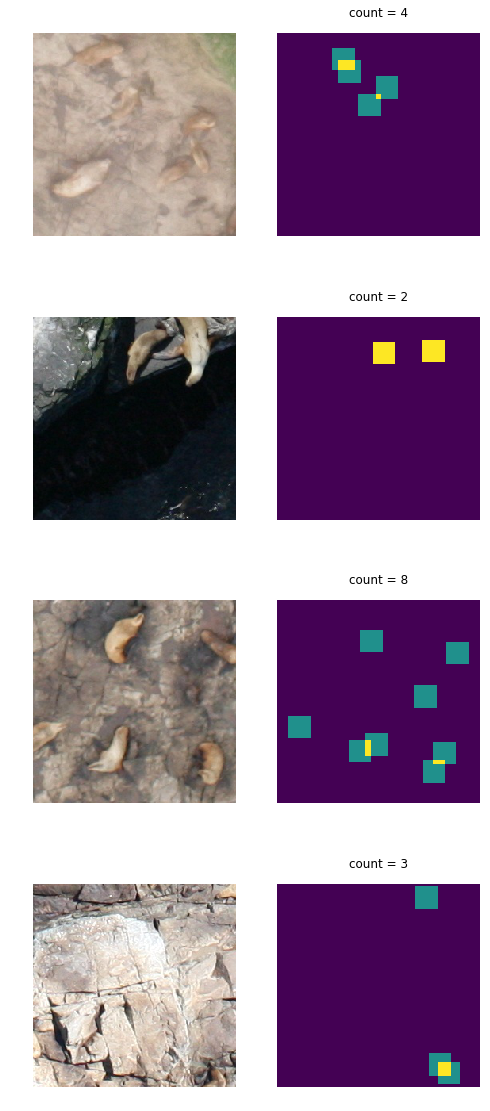

In [9]:
# visualize the batch oftraining samples : 
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(8,20))
shift = 50

for i in range(4):
    axes[i,0].imshow((batch_x[i]).astype(np.uint8))
    axes[i,1].matshow(batch_y[i,:,:,0])
    axes[i,1].set_title('count = {}'.format(counts[i]))
    axes[i,0].axis('off')
    axes[i,1].axis('off')

In [10]:
# opened Iterator where just for the demo
# we can close it : 
h5_iterator_train.close()
h5_iterator_val.close()

In [12]:
# here we create new Iterators which apply normalization  
h5_iterator_train = h5_generator_train.flow(x='imgs', y='target_imgs', normalization=True,
                                            batch_size=BATCH_SIZE, shuffle=True)
h5_iterator_val = h5_generator_val.flow(x='imgs', y='target_imgs', normalization=True,
                                        batch_size=BATCH_SIZE, shuffle=False)

In [13]:
# then with the method .next() we can generate one batch of data
# `with_counts=True` : return an array containing the number of sea lion per image
batch_x, batch_y, counts = h5_iterator_val.next(with_counts=True)
print("batch_x : {}  |  {}".format(batch_x.shape, batch_x.dtype))
print("batch_y : {}  |  {}".format(batch_y.shape, batch_y.dtype))
print("counts : {}  |  {}".format(counts.shape, counts.dtype))

batch_x : (4, 256, 256, 3)  |  float32
batch_y : (4, 288, 288, 1)  |  float32
counts : (4,)  |  uint8


# Create the Count-Ception network 

- here : same network as described in the paper 

In [14]:
# function to create Inception and Conv blocks as described in the paper  
from network_utils import ConvBlock, InceptionBlock

In [1]:
!cat network_utils.py

import keras


def ConvBlock(input_tensor, filters, kernel_size, padding, padding_type='valid'):
  if padding != 0:
    padded = keras.layers.ZeroPadding2D(padding)(input_tensor)
  else:
    padded = input_tensor

  conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size,
                             padding=padding_type)(padded)

  bn = keras.layers.BatchNormalization()(conv)
  activated = keras.layers.LeakyReLU(0.01)(bn)

  return activated


def InceptionBlock(input_tensor, n_fmaps_1x1, n_fmaps_3x3):
  conv1x1 = ConvBlock(input_tensor, n_fmaps_1x1, 1, 0)
  conv3x3 = ConvBlock(input_tensor, n_fmaps_3x3, 3, 1)
  return keras.layers.concatenate([conv1x1, conv3x3])

In [15]:
# input layer : where 256x256 rgb images will be feed
input_layer = keras.layers.Input(shape=(256, 256, 3))

x = ConvBlock(input_layer, 64, 3, padding=PATCH_SIZE, padding_type='valid')

x = InceptionBlock(x, 16, 16)
x = InceptionBlock(x, 16, 32)

x = ConvBlock(x, 16, 14, padding=0, padding_type='valid')

x = InceptionBlock(x, 112, 40)
x = InceptionBlock(x, 48, 40)
x = InceptionBlock(x, 64, 48)

x = ConvBlock(x, 32, 18, padding=0)
x = ConvBlock(x, 64, 1, padding=0)
x = ConvBlock(x, 64, 1, padding=0)

x = keras.layers.Conv2D(1, 1)(x)
final = keras.layers.LeakyReLU(0.01)(x)

model = keras.models.Model(inputs=input_layer, outputs=final)

In [16]:
# plot information about the model
# input : 256x256x3 images
# ouput : 288x288 count map
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 320, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 318, 318, 64) 1792        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 318, 318, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_l

In [17]:
# L1 loss (absolute_error)
# I choosed to use Adam optimizer
# This optimizer, also based on gradient descent is easier to use : no hyper-parameters to tune !
# For more experiements : check other optimizers (Momentum, RMSprop, ...)
model.compile(optimizer='adam', loss=keras.losses.mean_absolute_error)

## Create Keras callbacks to monitor the training 

In [18]:
# create an empty directory for model checkpoints
if not os.path.isdir('checkpoints/'):
    os.makedirs('checkpoints/')

In [19]:
# this callback will save the best model (evaluated on the validation set)
best_checkpoint = keras.callbacks.ModelCheckpoint(filepath="checkpoints/best.h5", save_best_only=True,
                                                  verbose=1, save_weights_only=True)

# this callback will make checkpoints at every epoch 
regular_checkpoint = keras.callbacks.ModelCheckpoint(filepath="checkpoints/model-cp.{epoch:02d}-{val_loss:.5f}.h5",
                                                     verbose=1, save_weights_only=True)

callbacks = [best_checkpoint, regular_checkpoint]

In [20]:
# launch the training ! 
# need to provide data iterator for training and validation 
# number of batches to see in '1 epoch' for training 
# and number of batches to see for validation purpose
history = model.fit_generator(h5_iterator_train,
                              steps_per_epoch=num_samples_train//BATCH_SIZE,
                              epochs=NUM_EPOCHS,
                              verbose=1,
                              callbacks=callbacks,
                              validation_data=h5_iterator_val,
                              validation_steps=num_samples_val//BATCH_SIZE)

Epoch 1/10
244/245 [============================>.] - ETA: 1s - loss: 0.0656Epoch 00001: val_loss improved from inf to 0.04328, saving model to checkpoints/best.h5
Epoch 00001: saving model to checkpoints/model-cp.01-0.04328.h5
245/245 [==============================] - 329s 1s/step - loss: 0.0657 - val_loss: 0.0433
Epoch 2/10
244/245 [============================>.] - ETA: 1s - loss: 0.0534Epoch 00002: val_loss did not improve
Epoch 00002: saving model to checkpoints/model-cp.02-0.05680.h5
245/245 [==============================] - 319s 1s/step - loss: 0.0533 - val_loss: 0.0568
Epoch 3/10
244/245 [============================>.] - ETA: 1s - loss: 0.0549Epoch 00003: val_loss did not improve
Epoch 00003: saving model to checkpoints/model-cp.03-0.04813.h5
245/245 [==============================] - 320s 1s/step - loss: 0.0548 - val_loss: 0.0481
Epoch 4/10
244/245 [============================>.] - ETA: 1s - loss: 0.0571Epoch 00004: val_loss improved from 0.04328 to 0.04213, saving model t

In [ ]:
# load the best model 
model.load_weights("checkpoints/best.h5")

In [25]:
# load a bath of samples (from the same image)
data_test = np.load('examples.npy').item()
imgs_b = data_test['imgs'].astype(np.float32)
target_imgs_b = data_test['targts'].astype(np.float32)
counts_b = data_test['counts']

In [26]:
# apply the same normalization as for training step 
imgs_b /= 127.5
imgs_b -= 1.

In [44]:
# apply the model : get batch of 'count-maps'
pred_y = model.predict(imgs_b, batch_size=4)

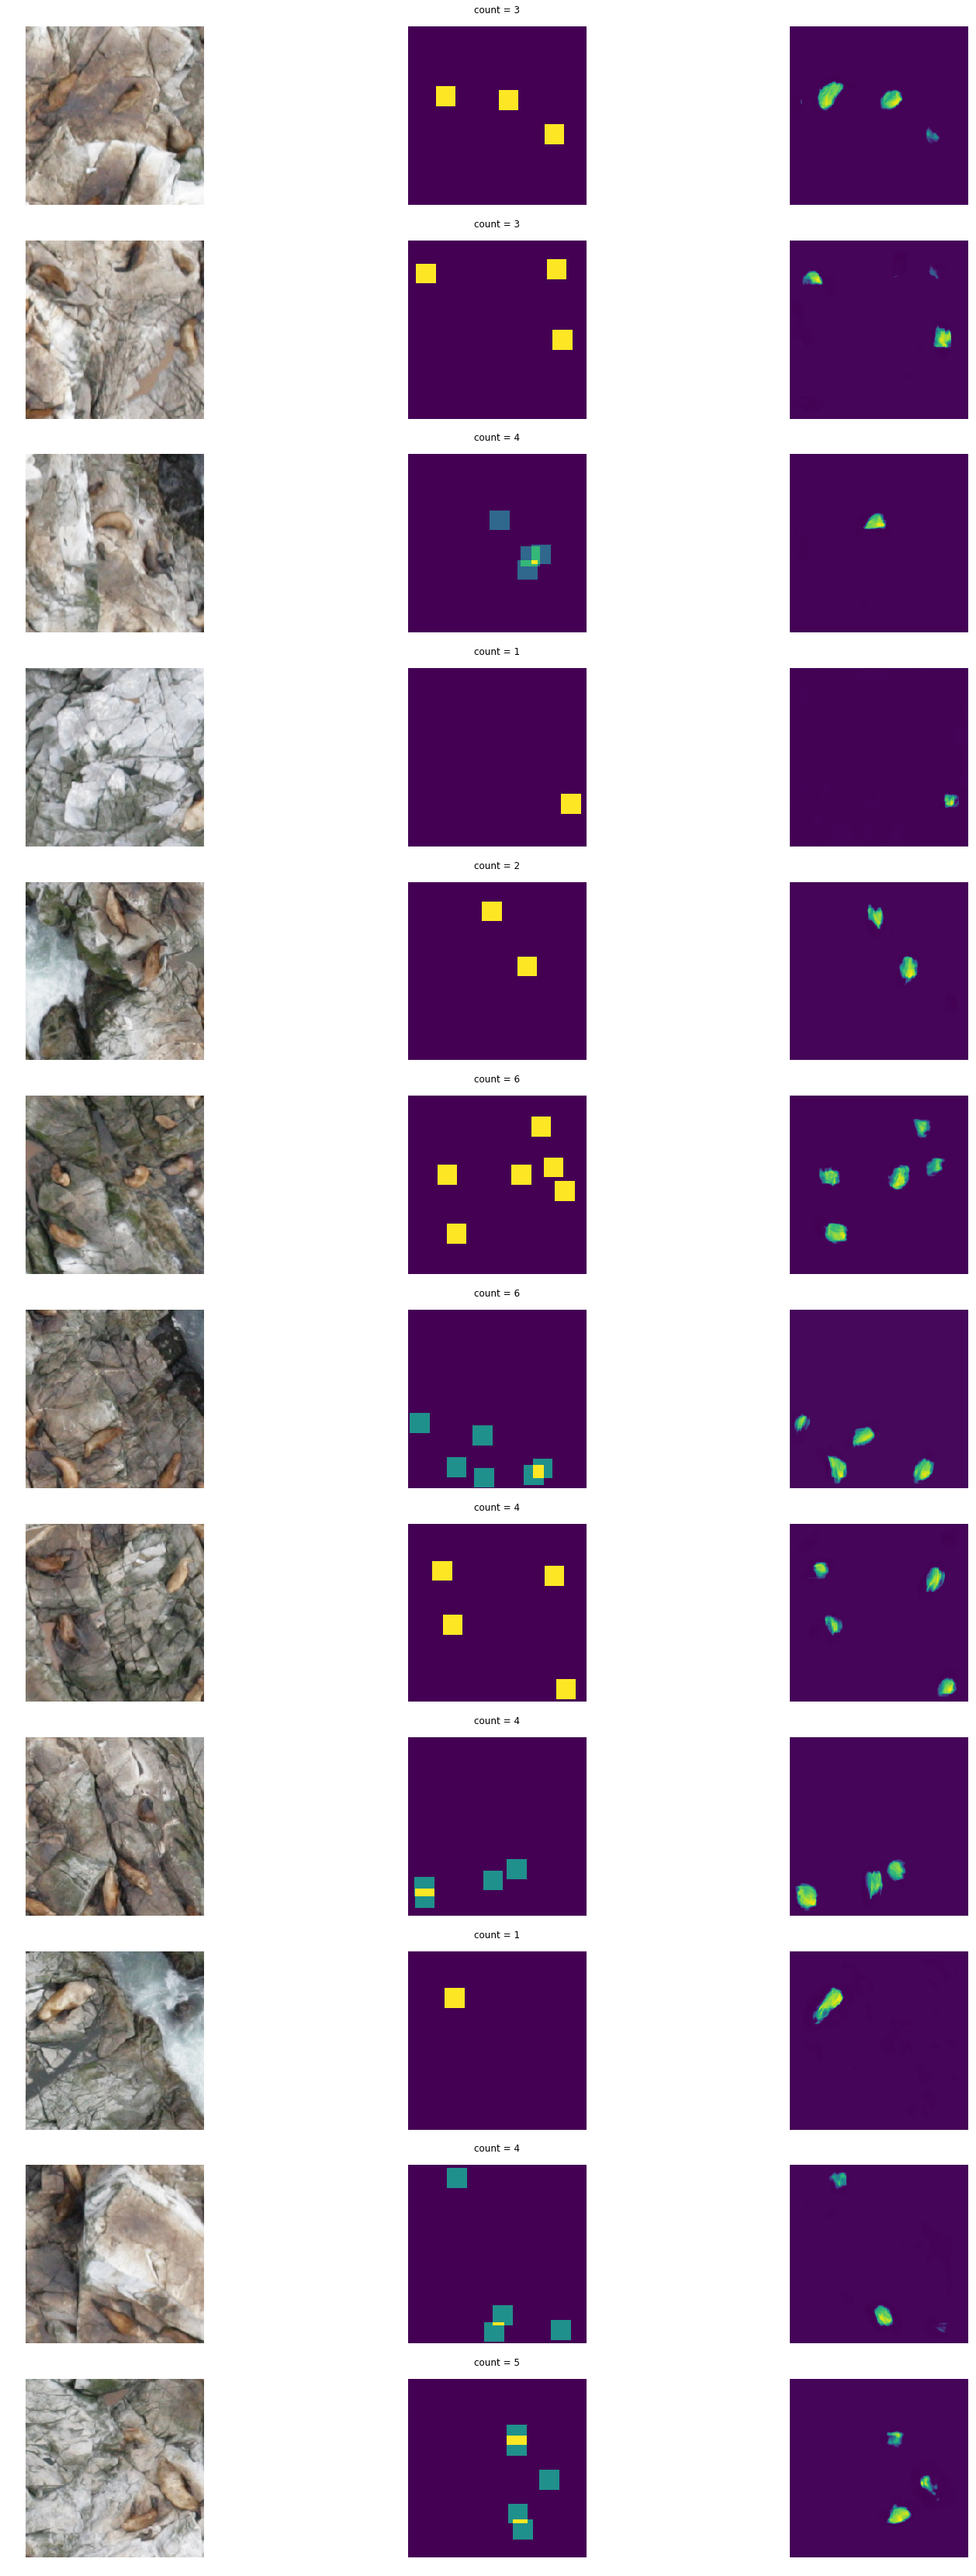

In [50]:
# visualize some training samples : 
fig, axes = plt.subplots(ncols=3, nrows=12, figsize=(25,60))
shift = 0

for i in range(12):
    axes[i,0].imshow(((imgs_b+1.0)*127.5)[i+shift].astype(np.uint8))
    axes[i,1].matshow(target_imgs_b[i+shift,:,:])
    axes[i,2].matshow(pred_y[i+shift,:,:,0])
    
    axes[i,0].axis('off')
    axes[i,1].axis('off')
    axes[i,2].axis('off')